## Scrape NCBI for Genome Stats!!! ##

The goal of this script is to automagically get a nice table and figure describing the state of the EBP in terms of genomes available at NCBI!  
The link is https://www.ncbi.nlm.nih.gov/assembly?term=eucaryotes  but this is done automatically below
The plan is to download the table, parse the data and present it a nice way automatically for easy updates in the future.

### List of graphs and charts I want to make:
1. Assembly quality - x axis contig, y axis scaffold **Done!**
2. EBP quality assemblies by year      **Done!**
3. Draft quality assemblies by year      **Done!**
4. Families with an EBP quality assembly by year  **Done!**
5. Families with a draft quality assembly by year   **Done!**
6. Total assemblies or any kind by year **Done!**
7. Families with an assembly of any kind by year **Done!**
8. Funding by country (by species) **Done!**
9. Phase 1 Funding by number of families  - hmmm 
10. Funding by conversations ongoing...  **Done!**
11. Long read costs, read lengths and qualities **Save for a different notebook**
12. Estimated costs per assembly (Long reads + HiC + Assembly) (perhaps historical?) **Save for a different notebook**
13. Assemblies sliced by quality and taxonomic group - playing with!
14. Different column output for Species progress database or google sheet.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

### install entrez-direct to go straight to NCBI - it's a perl thing, but just run as a program from the command line.
__conda install entrez-direct__  

Many thanks to Vamsi Kodali -
RefSeq Data Scientist at NCBI for helping me  by providing this e-direct code below!!!

In [2]:
!esearch \
  -db assembly \
  -query 'txid2759[organism] AND latest[filter] NOT derived_from_surveillance_project[filter] NOT anomalous[filter]' \
| esummary \
| xtract \
  -pattern DocumentSummary \
  -element SpeciesName,ContigN50,ScaffoldN50,AssemblyStatus,AssemblyAccession,AsmReleaseDate_GenBank,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn \
  > assembly_data.tsv
# thanks Vamsi!!!
! head -n3 assembly_data.tsv

Lasiodiplodia theobromae	876715	876715	Contig	GCA_012971845.1	2020/05/04 00:00	PRJNA388190	Lasiodiplodia theobromae (ascomycetes)	Beltsville Agricultural Research Center	SAMN07172427
Tigriopus kingsejongensis	1293995	1473880	Scaffold	GCA_012959195.1	2020/05/04 00:00	PRJNA625855	Tigriopus kingsejongensis (crustaceans)	Sungkyunkwan University	SAMN14610042
Fusarium graminearum	630157	1672063	Scaffold	GCA_012959185.1	2020/05/04 00:00	PRJNA625694	Fusarium graminearum (ascomycetes)	University of Massachusetts Amherst	SAMN14604992


In [3]:
!esearch \
  -db assembly \
  -query 'txid2759[organism] AND latest[filter] NOT derived_from_surveillance_project[filter] NOT anomalous[filter]' \
| esummary \
> have_a_look.txt
! head have_a_look.txt

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE DocumentSummarySet PUBLIC "-//NLM//DTD esummary assembly 20180216//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20180216/esummary_assembly.dtd">

<DocumentSummarySet status="OK">
<DocumentSummary>
<Id>7060571</Id>
	<RsUid></RsUid>
	<GbUid>19425068</GbUid>
	<AssemblyAccession>GCA_012971845.1</AssemblyAccession>
	<LastMajorReleaseAccession>GCA_012971845.1</LastMajorReleaseAccession>


In [4]:
!head -n100 have_a_look.txt

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE DocumentSummarySet PUBLIC "-//NLM//DTD esummary assembly 20180216//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20180216/esummary_assembly.dtd">

<DocumentSummarySet status="OK">
<DocumentSummary>
<Id>7060571</Id>
	<RsUid></RsUid>
	<GbUid>19425068</GbUid>
	<AssemblyAccession>GCA_012971845.1</AssemblyAccession>
	<LastMajorReleaseAccession>GCA_012971845.1</LastMajorReleaseAccession>
	<LatestAccession></LatestAccession>
	<ChainId>12971845</ChainId>
	<AssemblyName>ASM1297184v1</AssemblyName>
	<UCSCName></UCSCName>
	<EnsemblName></EnsemblName>
	<Taxid>45133</Taxid>
	<Organism>Lasiodiplodia theobromae (ascomycetes)</Organism>
	<SpeciesTaxid>45133</SpeciesTaxid>
	<SpeciesName>Lasiodiplodia theobromae</SpeciesName>
	<AssemblyType>haploid</AssemblyType>
	<AssemblyClass>haploid</AssemblyClass>
	<AssemblyStatus>Contig</AssemblyStatus>
	<WGS>QCYV01</WGS>
	<GB_BioProjects>
		<Bioproj>
			<BioprojectAccn>PRJNA388190</BioprojectAccn>
			<Bioproject

### All columns neeeded for species progress database ###

| Data Column                             |  Code generates                                                            |
|-----------------------------------------|----------------------------------------------------------------------------|
|Species Name (example: Homo sapiens)     | - yes                                                                      |
|English Name (example: Human)            | - sort of, will use NCBI organism                                          |
|Taxonomic Order                          | - yes - via gbif                                                           |
|Taxonomic Family (example: Hominidae)    | - yes - via gbif                                                           |
|endangered species?                      | - not sure where to pull this from                                         |
|General Taxanomic Group                  | - perhaps replace with order - far too manual a concept                    |
|Research Group(s)                        | - Using submitter organization                                             |
|Contact name(s)                          | - put in "for details see Asseembly Accession link"                        |
|Contact email(s)                         | - put in "for details see Asseembly Accession link"                        |
|Contact URL                              | - put in "for details see Asseembly Accession link"                        |
|Funded?                                  | - "In NCBI high contig N50" or "In NCBI contig N50 < 100kb, possible redo?"|
|Estimated Completion Date                | - "In NCBI high contig N50" or "In NCBI contig N50 < 100kb, possible redo?"|
|NCBI BioProject Link                     | - yes - Need to create link from BioProject Accession                      | 
|NCBI Assembly Link                       | - yes - Need to create link from Assembly Accession                        |
|Voucher Link (aspirational at this point)| - Not sure - see biosample accssion                                 |
|Sequencing Strategy                      | - yes - put in "for details see Asseembly Accession link"                  |
|contig N50                               | - yes                                                                      |
|scaffold N50                             | - yes                                                                      |

In [5]:
df = pd.read_csv("assembly_data.tsv", delimiter="\t", names=['species', 'contig_n50', 'scaffold_n50', 'status', 'ass_accession', 'ass_release_date', 'BioprojectAccn', 'Organism', 'SubmitterOrganization', 'BioSampleAccn'])
df.head(3)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn
0,Lasiodiplodia theobromae,876715,876715,Contig,GCA_012971845.1,2020/05/04 00:00,PRJNA388190,Lasiodiplodia theobromae (ascomycetes),Beltsville Agricultural Research Center,SAMN07172427
1,Tigriopus kingsejongensis,1293995,1473880,Scaffold,GCA_012959195.1,2020/05/04 00:00,PRJNA625855,Tigriopus kingsejongensis (crustaceans),Sungkyunkwan University,SAMN14610042
2,Fusarium graminearum,630157,1672063,Scaffold,GCA_012959185.1,2020/05/04 00:00,PRJNA625694,Fusarium graminearum (ascomycetes),University of Massachusetts Amherst,SAMN14604992


In [6]:
df['species'].count()

11832

In [7]:
# try to remove duplicate species, but keep the longest contig N50
df_sorted_no_dups = df.sort_values('contig_n50', ascending=False).drop_duplicates(subset=['species'])
df_sorted_no_dups = df_sorted_no_dups.reset_index(drop=True)
df_sorted_no_dups.head(3)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169
1,Bos grunniens x Bos taurus,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769


In [8]:
df_sorted_no_dups['species'].count()

5256

### Grab genera from species name 

In [9]:
#new_df = df_sorted_no_dups['species'].str.split(" ", n=1, expand=True)
new_df = df_sorted_no_dups['species'].str.split(" ", n=2, expand=True)

print(new_df.head(2))
df_sorted_no_dups['genera'] = new_df[0]
df_sorted_no_dups['species'] = new_df[0] + " " + new_df[1]
df_sorted_no_dups.head(3)

       0          1             2
0  Capra     hircus          None
1    Bos  grunniens  x Bos taurus


,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,genera
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,Capra
1,Bos grunniens,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487,Bos
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769,Homo


## Function to add higher taxonomic info to dataframe to allow by family or kingdom ect ##

In [10]:
# function to take a pandas lambda df thing species name and return a family name using the above ideas
### WHAT A COMPLETE PAIN IN THE ASS TO FIND OUT THIS IS WHAT WAS NEEDED
import requests
import re

def DF_get_family_name_given_species_name(df):
    """
    This is a short function to get a family name from the GBIF rest api given a genus_species name
    example input: Homo sapiens
    example return: Hominidae
    It requires re, requests functions
    NOTE!!! - Homo Sapiens doesn't work, Homo sapiens does - CHECK SPELLING
    """
    family = ''
    order = ''
    taxon_class = ''
    phylum = ''
    
    search_url_string = "http://api.gbif.org/v1/species/match?&name=" + df['species']
    res = requests.get(search_url_string)
    if res.status_code == 200:
        #print(res.text)
        #print("search string = ", search_url_string)
        search_obj_family = re.search(',"family":"(.+?)",', res.text)
        if search_obj_family:
            family = search_obj_family.group(1)
        else:
            #print("no family name returned for species name:", species)
            print(".", end="")
            family = None
        
        search_obj_order = re.search(',"order":"(.+?)",', res.text)
        if search_obj_order:
            order = search_obj_order.group(1)
        else:
            #print("no order name returned for species name:", species)
            print(".", end="")
            order = None
        
        search_obj_class = re.search(',"class":"(.+?)"', res.text)
        if search_obj_class:
            taxon_class = search_obj_class.group(1)
        else:
            #print("no class name returned for species name:", species)
            print(".", end="")
            taxon_class = None
        
        search_obj_phylum = re.search(',"phylum":"(.+?)"', res.text)
        if search_obj_phylum:
            phylum = search_obj_phylum.group(1)
        else:
            #print("no phylum name returned for species name:", species)
            print(".", end="")
            phylum = None
            
        search_obj_kingdom = re.search(',"kingdom":"(.+?)"', res.text)
        if search_obj_kingdom:
            kingdom = search_obj_kingdom.group(1)
        else:
            #print("no kingdom name returned for species name:", species)
            print(".", end="")
            kingdom = None
            
        #print("got:", family, order, taxon_class, phylum, kingdom)
        df['family'] = family
        df['order'] = order
        df['class'] = taxon_class
        df['phylum'] = phylum
        df['kingdom'] = kingdom
    
    return(df)

# test this out - # Create the pandas DataFrame 
data = [['Homo sapiens', "test"], ['Drosophila melanogaster', "test 2"]] 
df_test_taxon = pd.DataFrame(data, columns = ['species', 'something']) 
print(df_test_taxon)  

# test the above function
df_test_taxon = df_test_taxon.apply(DF_get_family_name_given_species_name, axis=1)
df_test_taxon

                   species something
0             Homo sapiens      test
1  Drosophila melanogaster    test 2


,species,something,family,order,class,phylum,kingdom
0,Homo sapiens,test,Hominidae,Primates,Mammalia,Chordata,Animalia
1,Drosophila melanogaster,test 2,Drosophilidae,Diptera,Insecta,Arthropoda,Animalia


## Takes a few minutes,  I made this only look up previously not looked up species  ##
it goes to GBIF for every species name - need to work on a multiple species at aa time lookup. ##
Note - it still takes a few minutes

In [11]:
# this takes time and goes to the Web for every species - uncomment line to redo as needed.
## uncomment the next line to run - takes 50 mins???
import time
start = time.time()
print("started timing")

# read previous version of NCBI_non_redundant_assemblies.csv into df here
df_previous_run = pd.read_csv('NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.csv')
df_previous_run_just_taxon_columns = df_previous_run[["species", "family", "order", "class", "phylum", "kingdom"]]

df_sorted_no_dups_add_previously_looked_up_data = df_sorted_no_dups.merge(df_previous_run_just_taxon_columns, on='species', how='left')
#print("\n", df_sorted_no_dups_add_previously_looked_up_data.head(), "\n")

df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup = df_sorted_no_dups_add_previously_looked_up_data[df_sorted_no_dups_add_previously_looked_up_data['family'].isnull()]
df_sorted_no_dups_add_previously_looked_up_data_is_OK = df_sorted_no_dups_add_previously_looked_up_data[df_sorted_no_dups_add_previously_looked_up_data['family'].notnull()]

number_of_species_with_successful_taxon_lookup = df_sorted_no_dups_add_previously_looked_up_data_is_OK['species'].count()
print("number of species with successful taxon lookup =", number_of_species_with_successful_taxon_lookup, "\n")

number_of_species_that_need_taxon_lookup = df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup['species'].count()
print("number of species that need a web taxon lookup =", number_of_species_that_need_taxon_lookup, "\n")

#for the ones with a new name

df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup = df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup.apply(DF_get_family_name_given_species_name, axis=1)
#print('\n', df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup, "\n")


# join everything back together again and resort
df_sorted_no_dups_with_taxon_data = pd.concat([df_sorted_no_dups_add_previously_looked_up_data_is_OK, df_sorted_no_dups_add_previously_looked_up_data_needs_web_lookup])

df_sorted_no_dups_with_taxon_data = df_sorted_no_dups_with_taxon_data.sort_values('contig_n50', ascending=False).drop_duplicates(subset=['species'])
df_sorted_no_dups_with_taxon_data = df_sorted_no_dups_with_taxon_data.reset_index(drop=True)
#print("\n\n", df_sorted_no_dups_with_taxon_data.head(10), '\n')

end = time.time()
print("\ntime to run =", end - start, "seconds\n")
df_sorted_no_dups_with_taxon_data.head(3)

started timing
number of species with successful taxon lookup = 4952 

number of species that need a web taxon lookup = 304 

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,genera,family,order,class,phylum,kingdom
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,Capra,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
1,Bos grunniens,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487,Bos,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia


In [12]:
# this is the old version that just looks up every species name on the web at gbif 
# takes time and goes to the Web for every species - uncomment line to redo as needed.
## uncomment the next line to run - takes 30 mins???
# It is left here incase you need to remake the 'NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.csv' file for some reason
# NOTE there is also 'NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.csv.backup' which you can copy and rename if necessary

import time
start = time.time()
print("started timing at", start)
#df_sorted_no_dups_with_taxon_data = df_sorted_no_dups.apply(DF_get_family_name_given_species_name, axis=1)
end = time.time()
print("finished timing at", end)
print("\ntime to run =", end - start, "seconds\n")
df_sorted_no_dups_with_taxon_data.head(3)

started timing at 1588807306.614569
finished timing at 1588807306.615017

time to run = 0.00044798851013183594 seconds



,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,genera,family,order,class,phylum,kingdom
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,Capra,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
1,Bos grunniens,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487,Bos,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia


### Add EBP Quality Status and Print to File for Tracking website

In [13]:
print("Number of species with a genome =", df_sorted_no_dups_with_taxon_data['species'].count())
df_sorted_no_dups_with_taxon_data.to_excel('NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.xls')
df_sorted_no_dups_with_taxon_data.to_csv('NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.csv')
df_sorted_no_dups_with_taxon_data.to_csv('NCBI_Genome_stats_images/NCBI_non_redundant_assemblies.csv.backup') # just in case I delete the other one 
df_sorted_no_dups_with_taxon_data.head(3)

Number of species with a genome = 5019


,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,genera,family,order,class,phylum,kingdom
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,Capra,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
1,Bos grunniens,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487,Bos,Bovidae,Artiodactyla,Mammalia,Chordata,Animalia
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia


### Re-order columns to match tracking website info we are asking of EBP collaborators

# should be:
# Species Name (example: Homo sapiens)	- yes
English Name (example: Human)	- sort of, will use NCBI organism
Taxonomic Order	- yes - via gbif
Taxonomic Family (example: Hominidae)	- yes - via gbif
endangered species?	- not sure where to pull this from
General Taxanomic Group	- perhaps replace with order - far too fuzzy a concept
Research Group(s)	- Using submitter organization
Contact name(s)	- put in "for details see Assembly Accession link"
Contact email(s)	- put in "for details see Assembly Accession link"
Contact URL	- put in "for details see Assembly Accession link"
Funded?	- "In NCBI high contig N50" or "In NCBI contig N50 < 100kb, possible redo?"
Estimated Completion Date	- "In NCBI high contig N50" or "In NCBI contig N50 < 100kb, possible redo?"
NCBI BioProject Link	- yes - Need to create link from BioProject Accession
NCBI Assembly Link	- yes - Need to create link from Assembly Accession
Voucher Link (aspirational at this point)	- Not sure - see biosample accssion
Sequencing Strategy	- yes - put in "for details see Assembly Accession link"
contig N50	- yes
scaffold N50

In [14]:
df_sorted_no_dups_with_taxon_data['contact_name'] = "see assembly accession link"
df_sorted_no_dups_with_taxon_data['contact_email'] = "see assembly accession link"
df_sorted_no_dups_with_taxon_data['contact_url'] = "see assembly accession link"
df_sorted_no_dups_with_taxon_data['funded'] = "in NCBI"
df_sorted_no_dups_with_taxon_data['estimated_completion_date'] = "in NCBI"
df_sorted_no_dups_with_taxon_data['sequencing_strategy'] = "see assembly accession link"

list(df_sorted_no_dups_with_taxon_data.columns.values)

['species',
 'contig_n50',
 'scaffold_n50',
 'status',
 'ass_accession',
 'ass_release_date',
 'BioprojectAccn',
 'Organism',
 'SubmitterOrganization',
 'BioSampleAccn',
 'genera',
 'family',
 'order',
 'class',
 'phylum',
 'kingdom',
 'contact_name',
 'contact_email',
 'contact_url',
 'funded',
 'estimated_completion_date',
 'sequencing_strategy']

In [15]:
df_re_ordered_columns_for_species_in_progress_tracking_website = df_sorted_no_dups_with_taxon_data[['species','Organism', 'order','family', 'SubmitterOrganization', 'contact_name', 'contact_email', 'contact_url', 'funded', 'estimated_completion_date', 'BioprojectAccn','ass_accession', 'BioSampleAccn', 'sequencing_strategy', 'contig_n50', 'scaffold_n50']]
df_re_ordered_columns_for_species_in_progress_tracking_website.to_excel('NCBI_Genome_stats_images/NCBI_assemblies_for_species_tracking_website.xls')
df_re_ordered_columns_for_species_in_progress_tracking_website.to_csv('NCBI_Genome_stats_images/NCBI_assemblies_for_species_tracking_website.csv')
df_re_ordered_columns_for_species_in_progress_tracking_website.head(3)


,species,Organism,order,family,SubmitterOrganization,contact_name,contact_email,contact_url,funded,estimated_completion_date,BioprojectAccn,ass_accession,BioSampleAccn,sequencing_strategy,contig_n50,scaffold_n50
0,Capra hircus,Capra hircus (goat),Artiodactyla,Bovidae,Sher-e-Kashmir University of Agricultural Scie...,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,PRJNA485388,GCA_009823495.1,SAMN09789169,see assembly accession link,87277385,87277385
1,Bos grunniens,Bos grunniens x Bos taurus (dzo),Artiodactyla,Bovidae,University of Nebraska - Lincoln,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,PRJNA551500,GCA_009493645.1,SAMN12153487,see assembly accession link,72336424,104384344
2,Homo sapiens,Homo sapiens (human),Primates,Hominidae,T2T Consortium,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,PRJNA559484,GCA_009914755.1,SAMN03255769,see assembly accession link,71707030,90050182


In [16]:
df_sorted_no_dups_with_taxon_data['species'].count()

5019

### Plot of Contig N50 vs Scaffold N50

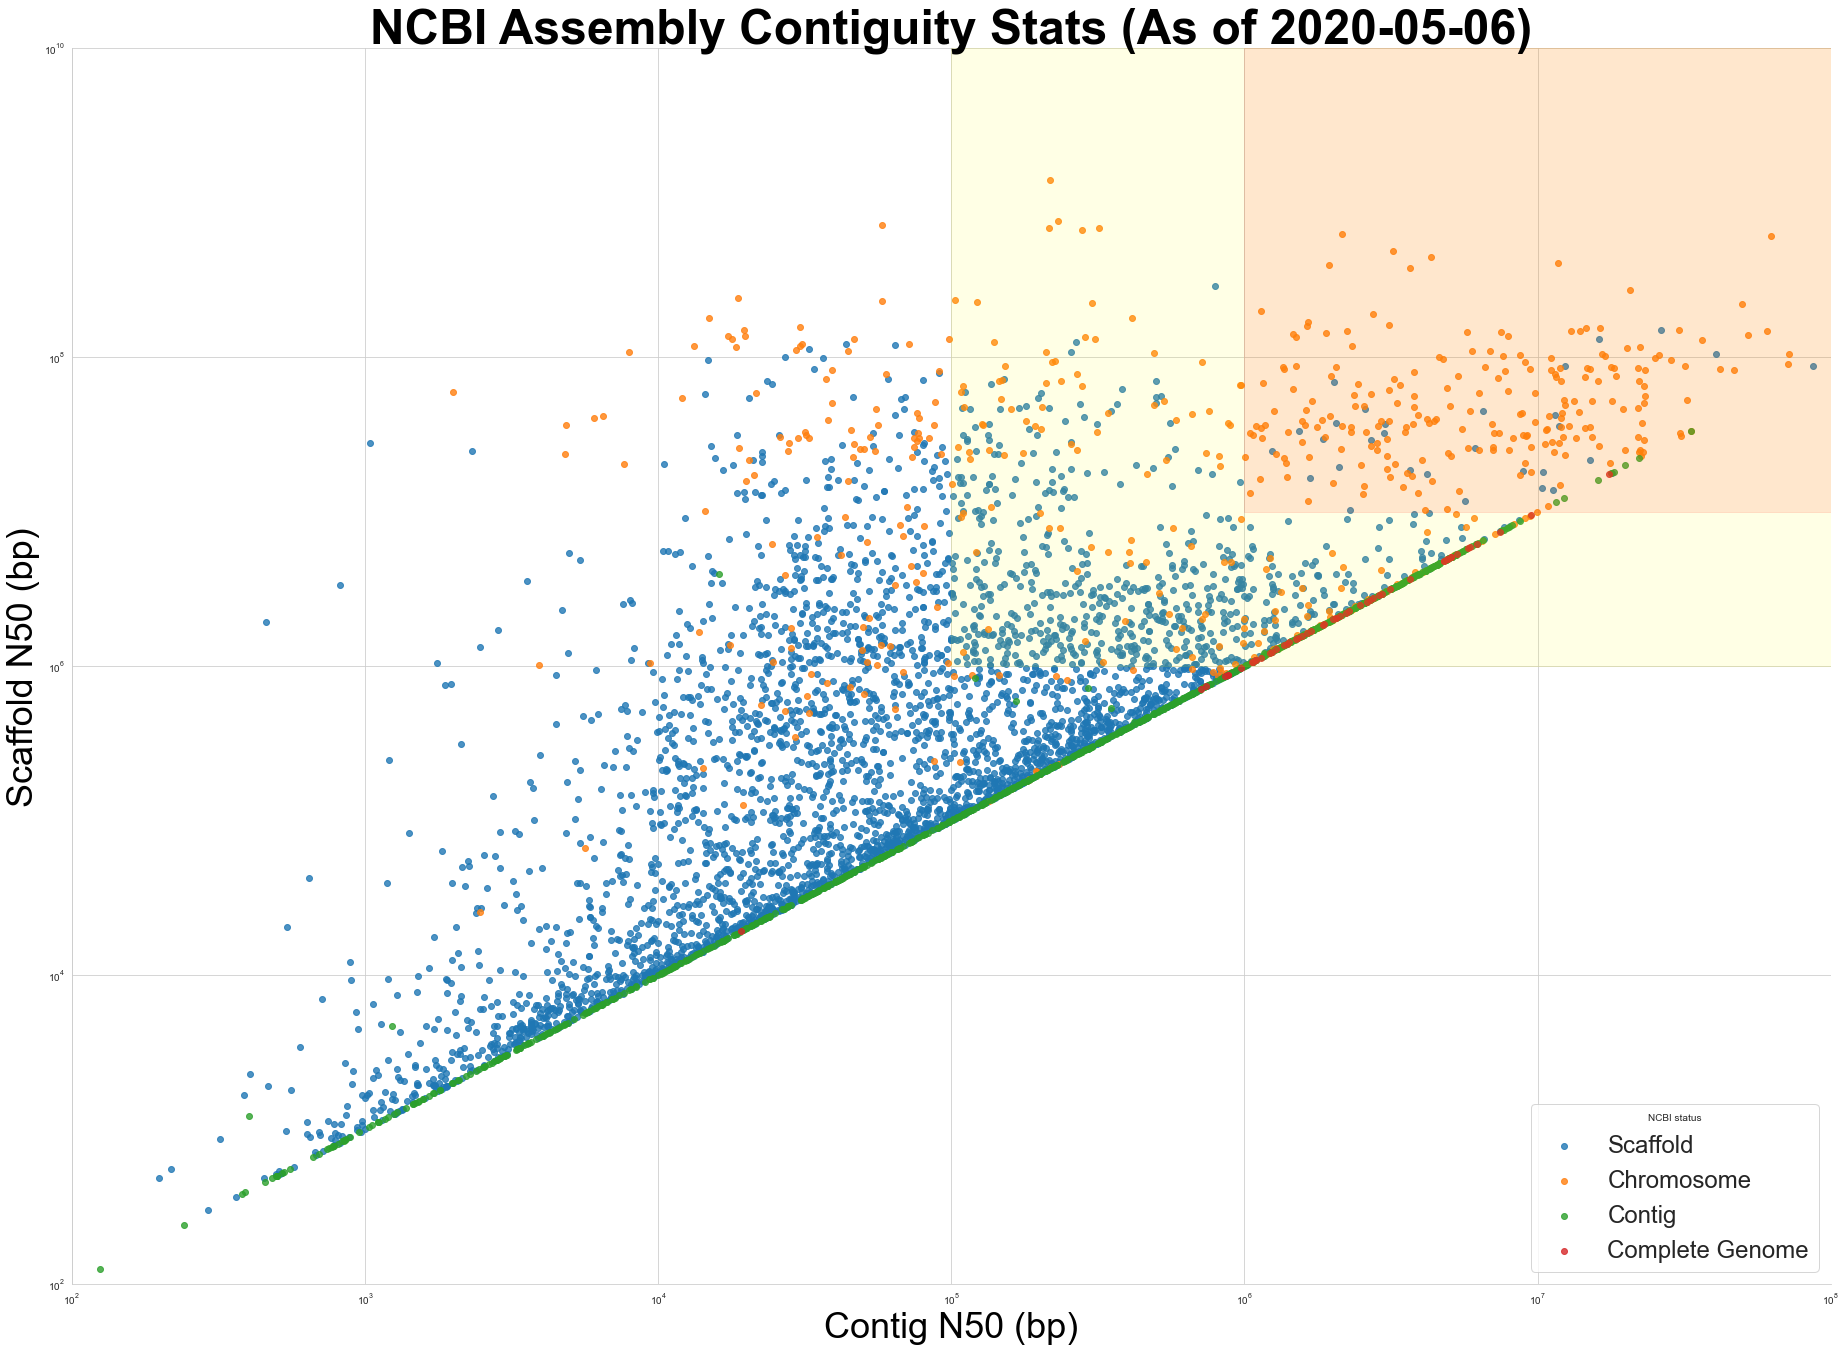

In [17]:
date = datetime.date.today()
sns.set_style("whitegrid")

g = sns.lmplot(x='contig_n50', y='scaffold_n50', data=df_sorted_no_dups_with_taxon_data, hue='status', fit_reg=False, height=18, aspect=1.4, legend_out=False)

# Set the `yscale` and other things
g.set(yscale="log")
g.set(xscale="log")
g.set(ylim=[100, 10000000000])
g.set(xlim=[100, 100000000])
#plt.rcParams.update({'label.size': 22})
plt.rc('xtick', labelsize=20)

plt.axvspan(1000000, 10000000000, ymin=0.625, ymax=1, alpha=0.1, color='red')
plt.axvspan(100000, 1000000000, ymin=0.5, ymax=1, alpha=0.1, color='yellow')

plt.xlabel('Contig N50 (bp)', fontweight='normal', color = 'black', fontsize=36, horizontalalignment='center')
plt.ylabel('Scaffold N50 (bp)', fontweight='normal', color = 'black', fontsize=36, horizontalalignment='center')
title_string = "NCBI Assembly Contiguity Stats (As of " + str(date.today()) + ")" 
plt.title(title_string, fontweight='bold', color = 'black', fontsize='48', loc='center')
plt.legend(loc = 'lower right', title = "NCBI status", fontsize = 24)

# Show plot
#plt.show()
file_name = "NCBI_Genome_stats_images/Assembly_contiguity_stats_" + str(date.today()) + ".png"
plt.savefig(file_name)

In [18]:
# try and plot assemblies by year - first add year column to dataframe
df_sorted_no_dups_with_taxon_data['date_time_test'] = pd.to_datetime(df_sorted_no_dups_with_taxon_data['ass_release_date'])
df_sorted_no_dups_with_taxon_data['year'] = df_sorted_no_dups_with_taxon_data['date_time_test'].apply(lambda x: x.year)
print(type(df_sorted_no_dups_with_taxon_data['year'][0]))
df_sorted_no_dups_with_taxon_data.head(3)

<class 'numpy.int64'>


,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,...,phylum,kingdom,contact_name,contact_email,contact_url,funded,estimated_completion_date,sequencing_strategy,date_time_test,year
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,...,Chordata,Animalia,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2019-12-31,2019
1,Bos grunniens,72336424,104384344,Chromosome,GCA_009493645.1,2019/11/04 00:00,PRJNA551500,Bos grunniens x Bos taurus (dzo),University of Nebraska - Lincoln,SAMN12153487,...,Chordata,Animalia,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2019-11-04,2019
2,Homo sapiens,71707030,90050182,Chromosome,GCA_009914755.1,2020/01/22 00:00,PRJNA559484,Homo sapiens (human),T2T Consortium,SAMN03255769,...,Chordata,Animalia,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2020-01-22,2020


In [19]:
# MAKE A DATA FRAME WITH HIGH QUALITY ASSEMBLIES
df_contig_N50_OK = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>1000000]
#df_contig_N50_OK.tail()
df_scaf_and_contig_OK = df_contig_N50_OK[df_contig_N50_OK['scaffold_n50']>10000000]
df_complete_genome = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['status'] == 'Complete Genome']
df_all_passing = pd.concat([df_scaf_and_contig_OK, df_complete_genome])
df_all_passing = df_all_passing.drop_duplicates()
print("number of species passing VGP qual (no dups):", df_all_passing['species'].count())


number of species passing VGP qual (no dups): 314


In [20]:
df_draft_contig_N50_OK = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>100000]
#df_contig_N50_OK.tail()
df_draft_scaf_and_contig_OK = df_draft_contig_N50_OK[df_draft_contig_N50_OK['scaffold_n50']>1000000]
df_complete_genome = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['status'] == 'Complete Genome']
df_draft_all_passing = pd.concat([df_draft_scaf_and_contig_OK, df_complete_genome])
print("number of draft all passing = ", df_draft_all_passing['species'].count())
df_draft_all_passing = df_draft_all_passing.drop_duplicates()
print("number of draft all passing after dup removal = ", df_draft_all_passing['species'].count())  # seems to have worked


number of draft all passing =  1411
number of draft all passing after dup removal =  1366


In [21]:
df_draft_all_passing.tail()

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,...,phylum,kingdom,contact_name,contact_email,contact_url,funded,estimated_completion_date,sequencing_strategy,date_time_test,year
834,Sporisorium scitamineum,875830,875830,Complete Genome,GCA_001010845.1,2015/05/20 00:00,PRJNA275631,Sporisorium scitamineum (smut fungi),University of Sao Paulo,SAMN03351821,...,Basidiomycota,Fungi,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2015-05-20,2015
845,Cyanidioschyzon merolae,859119,859119,Complete Genome,GCF_000091205.1,2010/06/14 00:00,PRJNA10792,PRJNA28057,Cyanidioschyzon merolae strain 10D (red algae),"National Institute of Genetics, Japan",...,Rhodophyta,Plantae,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2010-06-14,2010
908,Saccharomyces jurei,738741,738741,Complete Genome,GCA_900290405.1,2018/08/25 00:00,PRJEB24816,Saccharomyces jurei (budding yeasts),UOM-BCF,SAMEA104589863,...,Ascomycota,Fungi,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2018-08-25,2018
931,Ostreococcus sp.,708927,708927,Complete Genome,GCF_000092065.1,2010/06/14 00:00,PRJNA13044,PRJNA19407,Ostreococcus lucimarinus CCE9901 (green algae),US DOE Joint Genome Institute,...,Chlorophyta,Plantae,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2010-06-14,2010
3821,Leishmania adleri,19219,19219,Complete Genome,GCA_902369305.1,2019/10/16 00:00,PRJEB33887,Leishmania adleri (kinetoplastids),CBMSO,SAMEA5854542,...,Euglenozoa,Protozoa,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2019-10-16,2019


In [22]:
# just for me
print("total number of NCBI assemblies = ", df_sorted_no_dups_with_taxon_data['species'].count())

total number of NCBI assemblies =  5019


## Write a nice report - this needs to be put into Markdown for an easy nice output

In [23]:
# make a summary stats file
import datetime
date = datetime.date.today()
print("Date of NCBI stats download = ", date, "\n")

total_non_redundant_assemblies = df_sorted_no_dups_with_taxon_data['species'].count()
total_non_redundant_assemblies_percent = format(total_non_redundant_assemblies / 1500000 * 100, ".4f")

print("Total_non_redundant_assemblies = ", total_non_redundant_assemblies, "or", total_non_redundant_assemblies_percent, "%")
NCBI_complete_genome_assemblies = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['status'] == "Complete Genome"]['species'].count()
print("NCBI complete genome status = ", NCBI_complete_genome_assemblies)
NCBI_chromosome_assemblies = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['status'] == "Chromosome"]['species'].count()
print("NCBI chromosome status = ", NCBI_chromosome_assemblies, "\n")
#print("Question: What is the definition of complete genome and or chromosome status at NCBI???")

contig_N50_greater_than_1Mb = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>1000000]['species'].count()
print("Contig_N50_greater_than_1Mb =", contig_N50_greater_than_1Mb)

scaffold_n50_greater_than_10Mb = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['scaffold_n50']>10000000]['species'].count()
print("Scaffold_n50_greater_than_10Mb =", scaffold_n50_greater_than_10Mb)

VGP_standard = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>=1000000][df_sorted_no_dups_with_taxon_data['scaffold_n50']>=10000000]['species'].count()
percent_VGP_standard = format(VGP_standard / 1500000 * 100, ".4f")
print("Meets VGP standard (1Mb contig N50, 10Mb Scaffold N50) =", VGP_standard, "or", percent_VGP_standard, "%\n")


contig_N50_greater_than_100Kb = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>100000]['species'].count()
print("Contig_N50_greater_than_100Kb =", contig_N50_greater_than_100Kb)

scaffold_n50_greater_than_1Mb = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['scaffold_n50']>1000000]['species'].count()
print("Scaffold_n50_greater_than_1Mb =", scaffold_n50_greater_than_1Mb)

Lower_standard = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['contig_n50']>=100000][df_sorted_no_dups_with_taxon_data['scaffold_n50']>=1000000]['species'].count()
percent_lower_standard = format(Lower_standard / 1500000 * 100, ".4f")
print("Meets draft standard (100kb contig N50, 1Mb scaffold N50) =", Lower_standard, "or", percent_lower_standard, "%")

print("\nNote: Percentages calculated using a total estimated described eukaryotic species of 1.5 million")

Date of NCBI stats download =  2020-05-06 

Total_non_redundant_assemblies =  5019 or 0.3346 %
NCBI complete genome status =  52
NCBI chromosome status =  539 

Contig_N50_greater_than_1Mb = 764
Scaffold_n50_greater_than_10Mb = 566
Meets VGP standard (1Mb contig N50, 10Mb Scaffold N50) = 263 or 0.0175 %

Contig_N50_greater_than_100Kb = 2335
Scaffold_n50_greater_than_1Mb = 1879
Meets draft standard (100kb contig N50, 1Mb scaffold N50) = 1359 or 0.0906 %

Note: Percentages calculated using a total estimated described eukaryotic species of 1.5 million


/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Cumulative Progress Charts #

In [24]:
# use a pivot table to get number of families in df_all_passing
#df_all_passing_by_family = df_all_passing.pivot_table(columns="species" , values='family')
#df_all_passing_by_family
print("total number of passing species = ", df_all_passing['species'].count())

df_all_passing_by_family = pd.pivot_table(df_all_passing, index=['family'])
#df_all_passing_by_family = df_all_passing.groupby(by='family')
print(df_all_passing_by_family.count())
print("total number of passing families = ", df_all_passing_by_family['contig_n50'].count())

total number of passing species =  314
contig_n50      185
scaffold_n50    185
year            185
dtype: int64
total number of passing families =  185


In [25]:
# and again for draft quality
print("total number of passing species = ", df_draft_all_passing['species'].count())
df_draft_all_passing_by_family = pd.pivot_table(df_draft_all_passing, index=['family'])
df_draft_all_passing_by_family.count()

total number of passing species =  1366


contig_n50      494
scaffold_n50    494
year            494
dtype: int64

In [26]:
print("total species = ", df_all_passing['species'].count())
min_year = df_all_passing['year'].min()
max_year = df_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative VGP quality species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_assembly = df_all_passing[df_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing = ",  cum_species_with_assembly)
    lst.append([int(year_count), int(cum_species_with_assembly)])

df_cumulative_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species

total species =  314
min_year =  2010 max_year =  2020


,Year,Cumulative VGP quality species represented
0,2010,3
1,2011,6
2,2012,6
3,2013,7
4,2014,11
5,2015,16
6,2016,20
7,2017,35
8,2018,81
9,2019,235


In [27]:
print("total species = ", df_draft_all_passing['species'].count())
#min_year = df_draft_all_passing['year'].min()
min_year = 2010
max_year = df_draft_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative 100kb contig N50 species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_draft_assembly = df_draft_all_passing[df_draft_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing draft qual = ",  cum_species_with_draft_assembly)
    lst.append([int(year_count), int(cum_species_with_draft_assembly)])

df_cumulative_draft_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_draft_species

total species =  1366
min_year =  2010 max_year =  2020


,Year,Cumulative 100kb contig N50 species represented
0,2010,17
1,2011,43
2,2012,60
3,2013,90
4,2014,134
5,2015,185
6,2016,331
7,2017,484
8,2018,728
9,2019,1126


In [28]:
print("total species = ", df_sorted_no_dups_with_taxon_data['species'].count())
#min_year = df_sorted_no_dups_with_taxon_data['year'].min()
min_year = 2010  # because a lot of older assemblies had updates - so not much before 2010 unless you look at the originals
max_year = df_sorted_no_dups_with_taxon_data['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Any assembly: Cumulative species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_any_assembly = df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['year'] <= year_count]['species'].count()
    #print("number of cumulative species any assembly quality = ",  cum_species_with_any_assembly)
    lst.append([int(year_count), int(cum_species_with_any_assembly)])

df_cumulative_species_any_assembly = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species_any_assembly

total species =  5019
min_year =  2010 max_year =  2020


,Year,Any assembly: Cumulative species represented
0,2010,74
1,2011,150
2,2012,251
3,2013,423
4,2014,682
5,2015,1016
6,2016,1475
7,2017,2027
8,2018,3171
9,2019,4402


In [29]:
# predictions for 2020, 2021, 2022, 2023
#df_predictions = df_cumulative_species_any_assembly
#df_predictions

# THIS BIT IS VERY MANUAL, BUT WITH A AUTOMATED GRAPH GENERATION SO I DON"T HAVE TO FUCK AROUND IN EXCEL MAKING THINGS LOOK PRETTY
df_Prediction_Chart_data = pd.DataFrame({
    "Historical" : [1109 ,1596, 2192, 3406, 4711, 4711, 4711, 4711],
    "Darwin" : [0, 0, 0, 0, 0, 1000, 2000, 4000],
    "USDA" : [0, 0, 0, 0, 0, 50, 50, 0],
    "CA" : [0, 0, 0, 0, 0, 25, 50, 75],
    "VGP" : [0, 0, 0, 0, 0, 100, 100, 100],
    "Australia" : [0, 0, 0, 0, 0, 25, 75, 0],
    "BGI" : [0, 0, 0, 0, 0, 300, 500, 1000],
    "Other" : [0, 0, 0, 0, 0, 471, 518, 570],
},  index = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

df_Prediction_Chart_data.drop([2015,2016], inplace=True)
print(df_Prediction_Chart_data)
df_Prediction_Chart_data

      Historical  Darwin  USDA  CA  VGP  Australia   BGI  Other
2017        2192       0     0   0    0          0     0      0
2018        3406       0     0   0    0          0     0      0
2019        4711       0     0   0    0          0     0      0
2020        4711    1000    50  25  100         25   300    471
2021        4711    2000    50  50  100         75   500    518
2022        4711    4000     0  75  100          0  1000    570


,Historical,Darwin,USDA,CA,VGP,Australia,BGI,Other
2017,2192,0,0,0,0,0,0,0
2018,3406,0,0,0,0,0,0,0
2019,4711,0,0,0,0,0,0,0
2020,4711,1000,50,25,100,25,300,471
2021,4711,2000,50,50,100,75,500,518
2022,4711,4000,0,75,100,0,1000,570


In [30]:
# THIS BIT IS VERY MANUAL, BUT WITH A AUTOMATED GRAPH GENERATION SO I DON"T HAVE TO FUCK AROUND IN EXCEL MAKING THINGS LOOK PRETTY
df_EBP_Genome_Prediction_Chart_data = pd.DataFrame({
    "Historical" : [16, 21, 38, 89, 242, 242, 242, 242],
    "Darwin" : [0, 0, 0, 0, 0, 1000, 2000, 4000],
    "USDA" : [0, 0, 0, 0, 0, 50, 50, 0],
    "CA" : [0, 0, 0, 0, 0, 25, 50, 75],
    "VGP" : [0, 0, 0, 0, 0, 100, 100, 100],
    "Australia" : [0, 0, 0, 0, 0, 25, 75, 0],
    "BGI" : [0, 0, 0, 0, 0, 300, 500, 1000],
    "Other" : [0, 0, 0, 0, 0, 18, 22, 26],
},  index = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

df_EBP_Genome_Prediction_Chart_data.drop([2015,2016], inplace=True)
df_EBP_Genome_Prediction_Chart_data

,Historical,Darwin,USDA,CA,VGP,Australia,BGI,Other
2017,38,0,0,0,0,0,0,0
2018,89,0,0,0,0,0,0,0
2019,242,0,0,0,0,0,0,0
2020,242,1000,50,25,100,25,300,18
2021,242,2000,50,50,100,75,500,22
2022,242,4000,0,75,100,0,1000,26


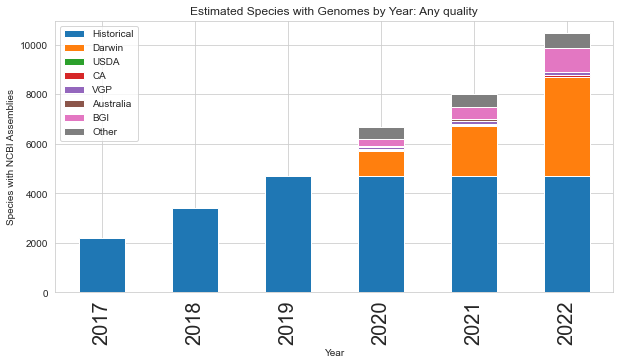

In [31]:
df_Prediction_Chart_data.plot.bar(stacked=True, figsize=(10,5))
plt.title('Estimated Species with Genomes by Year: Any quality')
plt.xlabel('Year')
plt.ylabel('Species with NCBI Assemblies')
file_name = "NCBI_Genome_stats_images/Predicted_Genome_Production_by_year_any_quality" + str(date.today()) + ".png"
plt.savefig(file_name)
#ax.legend(loc='upper left', frameon=False)
#df.plot()

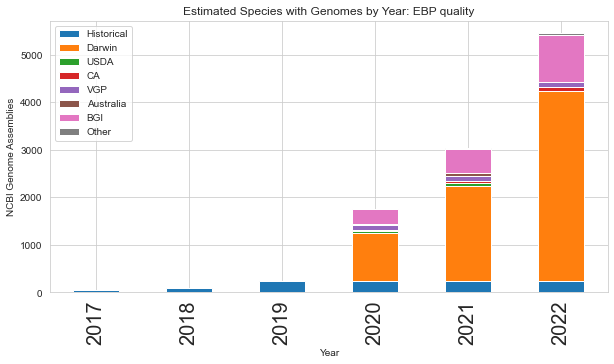

In [32]:
df_EBP_Genome_Prediction_Chart_data.plot.bar(stacked=True, figsize=(10,5))
plt.title('Estimated Species with Genomes by Year: EBP quality')
plt.xlabel('Year')
plt.ylabel('NCBI Genome Assemblies')
file_name = "NCBI_Genome_stats_images/Predicted_Genome_Production_by_year_EBP_quality" + str(date.today()) + ".png"
plt.savefig(file_name)

### Note there are a lot of updated and not original genomes in here,  
- lots of old genome assemblies replaced by an updated version - seemed to happen a lot in 2010  
- So I made 2010 the first year of the plot for now  
- Will think about a more accurate historical view later

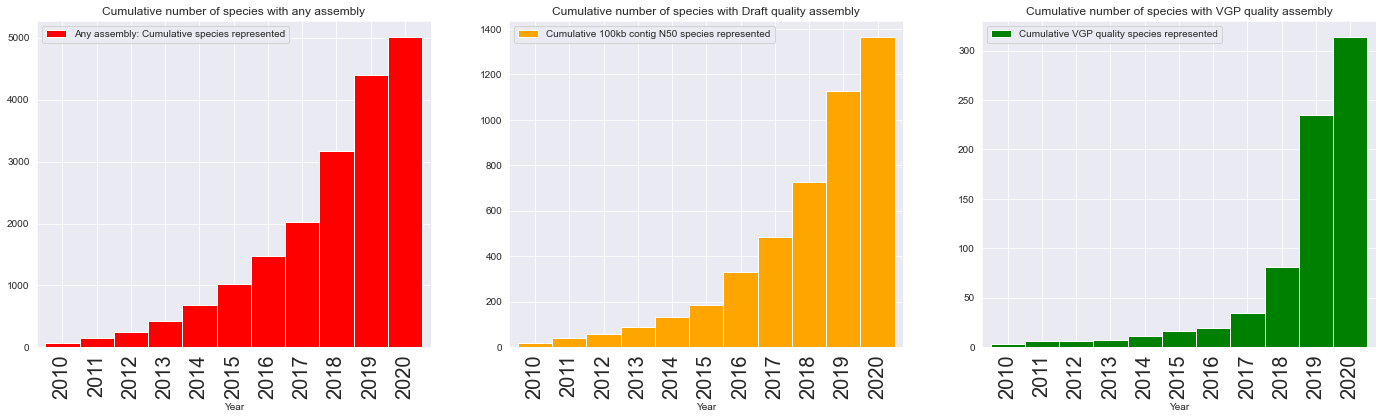

In [33]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(24,6))

df_cumulative_species_any_assembly.plot(ax=axes[0,0], x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly")
df_cumulative_draft_species.plot(ax=axes[0,1],  x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly')
df_cumulative_species.plot(ax=axes[0,2], x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly")

plt.savefig('NCBI_Genome_stats_images/Cumulative_species_by_year.png')

In [34]:
# keep cell in case I need a single plot
#sns.set_style('darkgrid')
#df_cumulative_species_any_assembly.plot(x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_any_assembly.png')

In [35]:
# Keep cell incase I need a single plot
#df_cumulative_draft_species.plot(x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly', figsize=(8,6))
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_Draft_quality_assembly.png')

In [36]:
# Keep cell in case I need a single plot
#df_cumulative_species.plot(x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_EBP_quality_assembly.png')

## Now I need to plot the same progress by different taxonomic rank  
- If I were smart this would be a cool loop with three charts for each rank in a cool grid pattern

In [37]:
df_all_passing.head(1)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,BioprojectAccn,Organism,SubmitterOrganization,BioSampleAccn,...,phylum,kingdom,contact_name,contact_email,contact_url,funded,estimated_completion_date,sequencing_strategy,date_time_test,year
0,Capra hircus,87277385,87277385,Scaffold,GCA_009823495.1,2019/12/31 00:00,PRJNA485388,Capra hircus (goat),Sher-e-Kashmir University of Agricultural Scie...,SAMN09789169,...,Chordata,Animalia,see assembly accession link,see assembly accession link,see assembly accession link,in NCBI,in NCBI,see assembly accession link,2019-12-31,2019


total species at this quality =  all : 5019
total species at this quality =  draft : 1366
total species at this quality =  VGP : 314


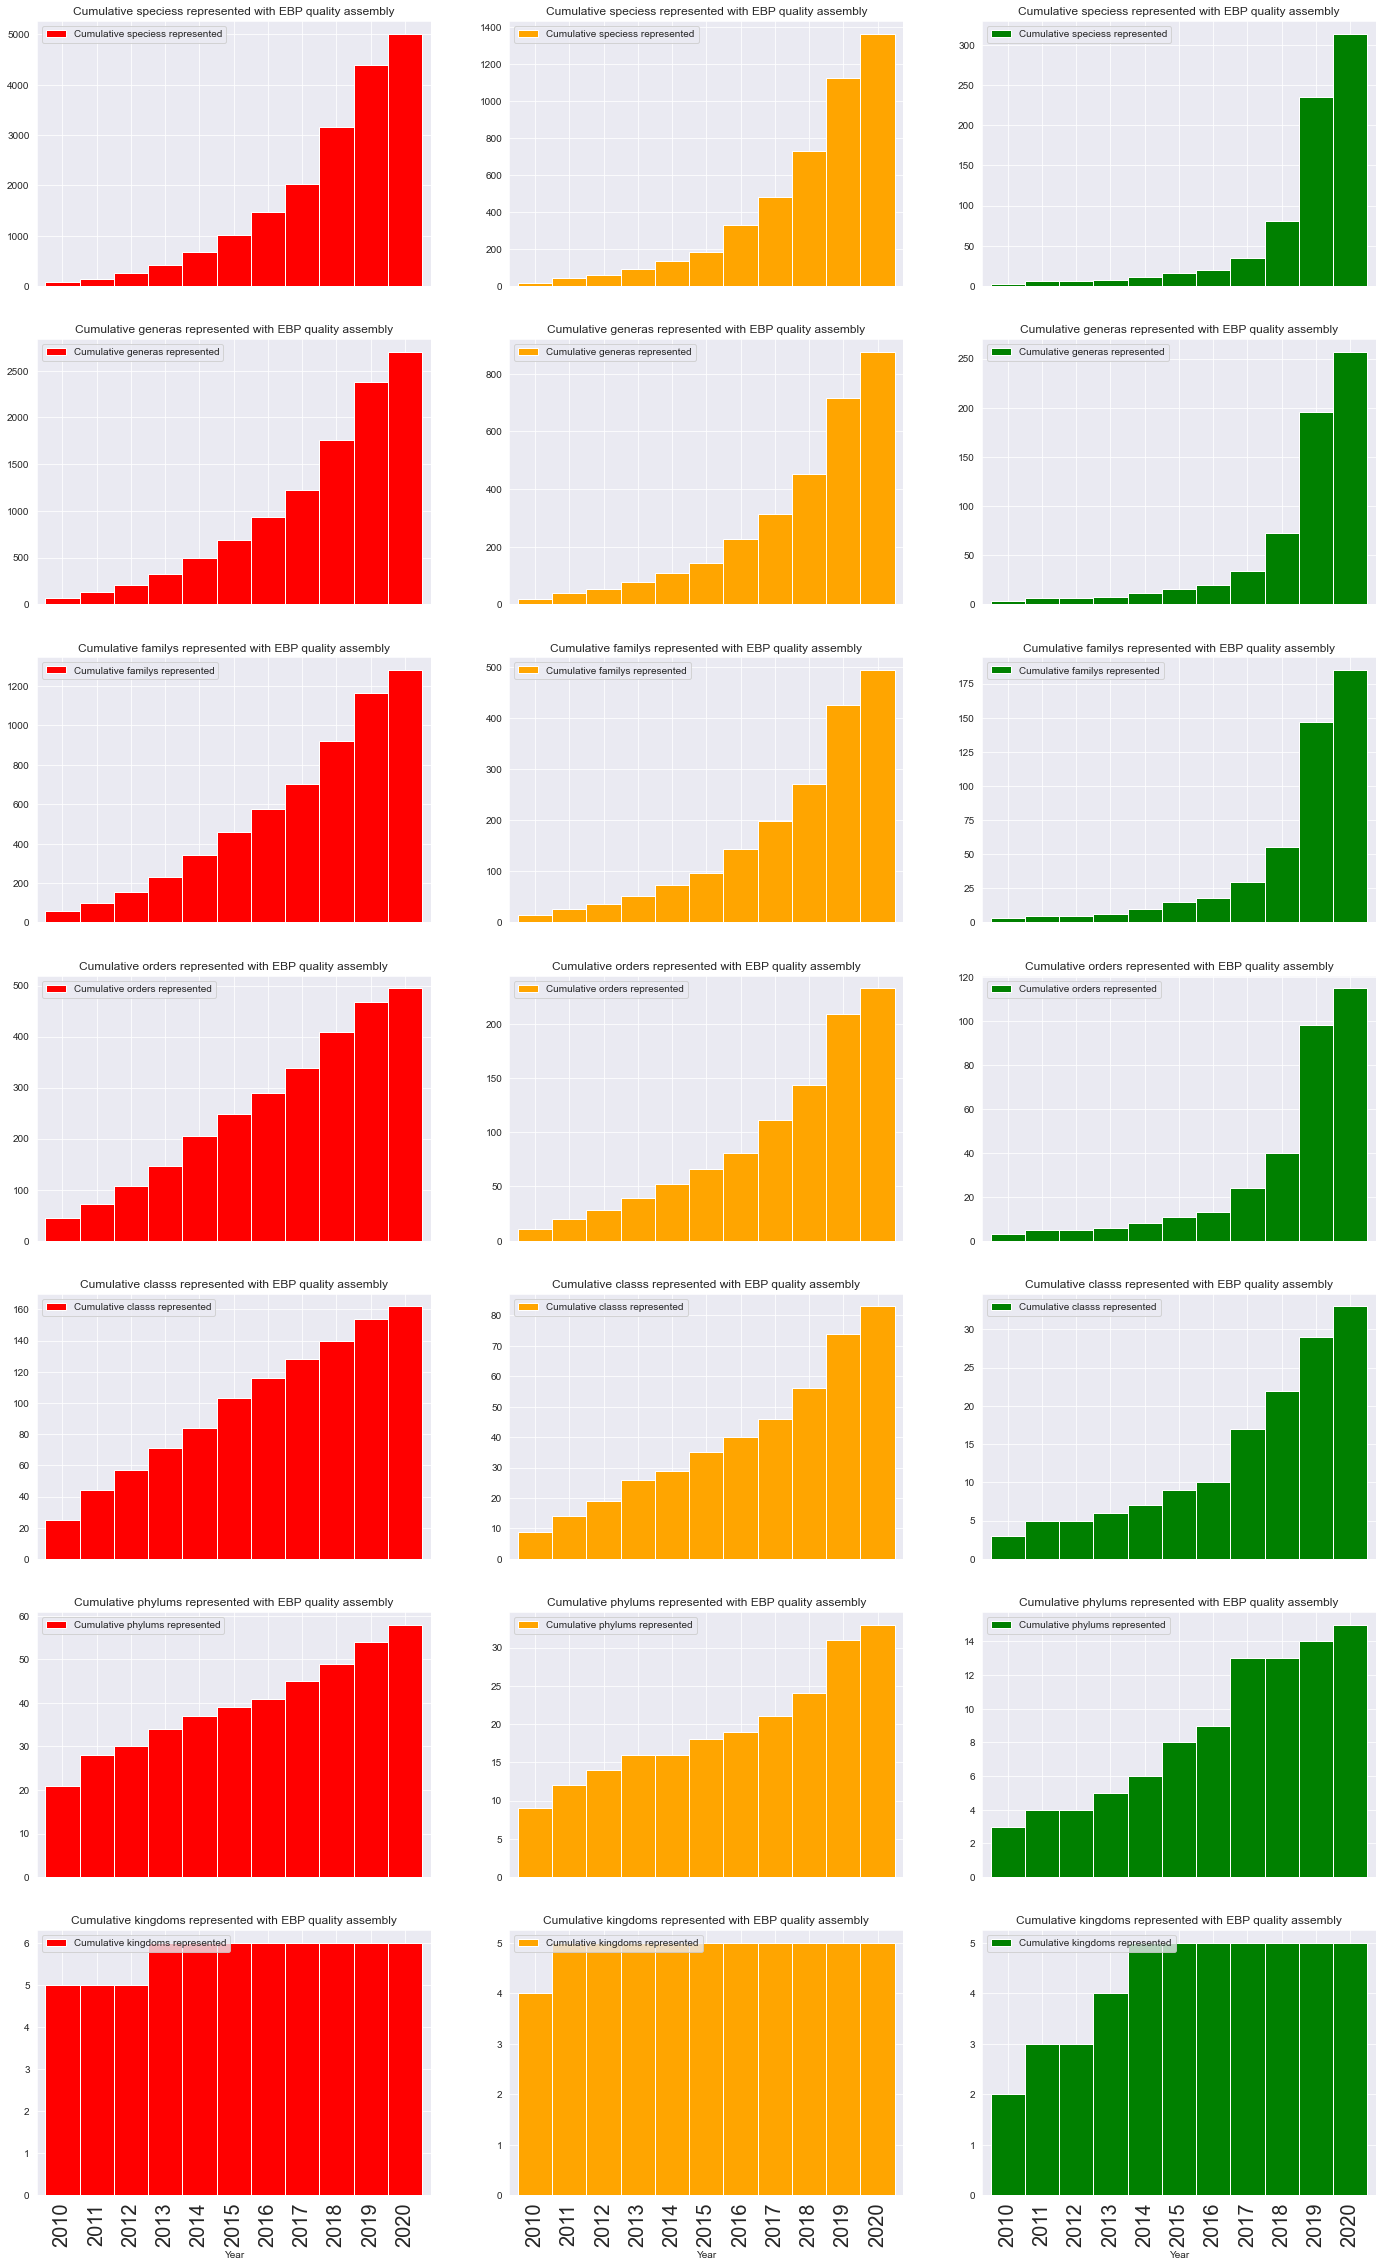

In [38]:
# trying to get all the charts in a single loop
df_sorted_no_dups_with_taxon_data.name = 'all'  # I named them for the coloring below
df_draft_all_passing.name = 'draft'
df_all_passing.name = 'VGP'

sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=7, ncols=3, squeeze=False, figsize=(24,40), sharex=True)

for loop_dfs in (df_sorted_no_dups_with_taxon_data, df_draft_all_passing, df_all_passing):
    print("total species at this quality = ", loop_dfs.name,":", loop_dfs['species'].count())
    for rank in ('species', 'genera', 'family', 'order', 'class', 'phylum', 'kingdom'):
        taxon_column = "Cumulative " + rank + "s represented"
        cols = ['Year', taxon_column]
        lst = []

        for year_count in range(min_year, max_year+1):
            #print("year = ", year_count)
            #print(df_all_passing[df_all_passing['year'] <= year_count]['species'].count())
            #print(loop_dfs[loop_dfs['year'] <= year_count]['species'].count())
            
            #familes_with_assembly = pd.pivot_table(df_all_passing[df_all_passing['year'] <= year_count], index=[rank])['contig_n50'].count()
            familes_with_assembly = pd.pivot_table(loop_dfs[loop_dfs['year'] <= year_count], index=[rank])['contig_n50'].count()
            
            #print("number of cumulative ", rank, " passing = ",  familes_with_assembly)
            lst.append([int(year_count), int(familes_with_assembly)])

        df_cumulative_families_represented = pd.DataFrame(lst, columns=cols)
        #df_cumulative_families_represented.set_index('Year', inplace=True)
        #print(df_cumulative_families_represented)

        title_label = taxon_column + " with EBP quality assembly"
        bar_color = 'orange'
        plot_col = 0
        plot_row = 0
        
        if loop_dfs.name == "all":
            bar_color = 'red'
            plot_col = 0
        elif loop_dfs.name == 'draft':
            bar_color = 'orange'
            plot_col = 1
        elif loop_dfs.name == 'VGP':
            bar_color = 'green'
            plot_col = 2
        
        if rank == 'species':
            plot_row = 0
        elif rank == 'genera':
            plot_row = 1
        elif rank == 'family':
            plot_row = 2      
        elif rank == 'order':
            plot_row = 3
        elif rank == 'class':
            plot_row = 4
        elif rank == 'phylum':
            plot_row = 5
        elif rank == 'kingdom':
            plot_row = 6

        df_cumulative_families_represented.plot(ax=axes[plot_row, plot_col], x='Year', y=taxon_column, kind='bar', width=1, color=bar_color, title=title_label )

plt.savefig('NCBI_Genome_stats_images/taxonomic_rank_progress_by_year.png')

### Now I need to break out the numbers by kingdom and phyla for the reporter ###

In [39]:
print(df_sorted_no_dups_with_taxon_data['phylum'].unique())

['Chordata' 'Tracheophyta' 'Arthropoda' 'Amoebozoa' 'Ascomycota'
 'Nematoda' None 'Platyhelminthes' 'Basidiomycota' 'Zygomycota' 'Mollusca'
 'Bryozoa' 'Myzozoa' 'Chlorophyta' 'Bigyra' 'Metamonada' 'Glomeromycota'
 'Echinodermata' 'Oomycota' 'Rhodophyta' 'Ochrophyta' 'Mycetozoa'
 'Chytridiomycota' 'Cnidaria' 'Cercozoa' 'Euglenozoa' 'Ciliophora'
 'Anthocerotophyta' 'Marchantiophyta' 'Bryophyta' 'Nematomorpha'
 'Charophyta' 'Choanozoa' 'Microsporidia' 'Cryptophyta' 'Glaucophyta'
 'Ctenophora' 'Placozoa' 'Dicyemida' 'Loukozoa' 'Tardigrada'
 'Acanthocephala' 'Rotifera' 'Phoronida' 'Brachiopoda' 'Annelida'
 'Myxozoa' 'Porifera' 'Sarcomastigophora' 'Haptophyta' 'Sulcozoa'
 'Nemertea' 'Orthonectida' 'Xenacoelomorpha' 'Hemichordata'
 'Cephalorhyncha' 'Percolozoa' 'Foraminifera' 'Onychophora']


In [40]:
df_sorted_no_dups_with_taxon_data['kingdom'].describe()

count      4879
unique        6
top       Fungi
freq       1972
Name: kingdom, dtype: object

In [41]:
df_sorted_no_dups_with_taxon_data['kingdom'].unique()

array(['Animalia', 'Plantae', 'Protozoa', 'Fungi', None, 'Chromista',
       'incertae sedis'], dtype=object)

Incertae sedis (Latin for "of uncertain placement") or problematica are terms used for a taxonomic group where its broader relationships are unknown or undefined. (Thanks Wikipedia!)

In [42]:
print("number of plants:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='Plantae']['species'].count())
print("number of animals:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='Animalia']['species'].count())
print("number of fungi:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='Fungi']['species'].count())
print("number of None:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']==None]['species'].count())
print("number of Protozoa:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='Protozoa']['species'].count())
print("number of Chromista:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='Chromista']['species'].count())
print("number of incertae sedis:", df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['kingdom']=='incertae sedis']['species'].count())

number of plants: 615
number of animals: 1949
number of fungi: 1972
number of None: 0
number of Protozoa: 134
number of Chromista: 206
number of incertae sedis: 3


In [43]:
df_species_seq_in_each_kingdom = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_kingdom

,species
kingdom,
Animalia,1949
Chromista,206
Fungi,1972
Plantae,615
Protozoa,134
incertae sedis,3


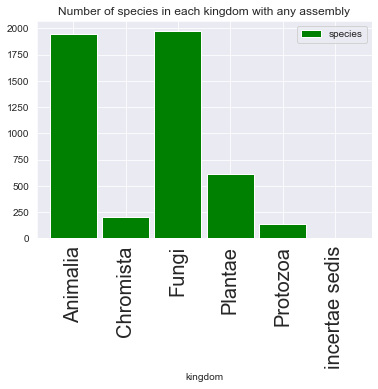

In [44]:
df_species_seq_in_each_kingdom.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each kingdom with any assembly')
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_kingdom.png')

In [45]:
df_species_seq_in_each_phylum = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data, index='phylum', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_phylum

,species
phylum,
Acanthocephala,1
Amoebozoa,24
Annelida,7
Anthocerotophyta,1
Arthropoda,587
Ascomycota,1447
Basidiomycota,430
Bigyra,8
Brachiopoda,1


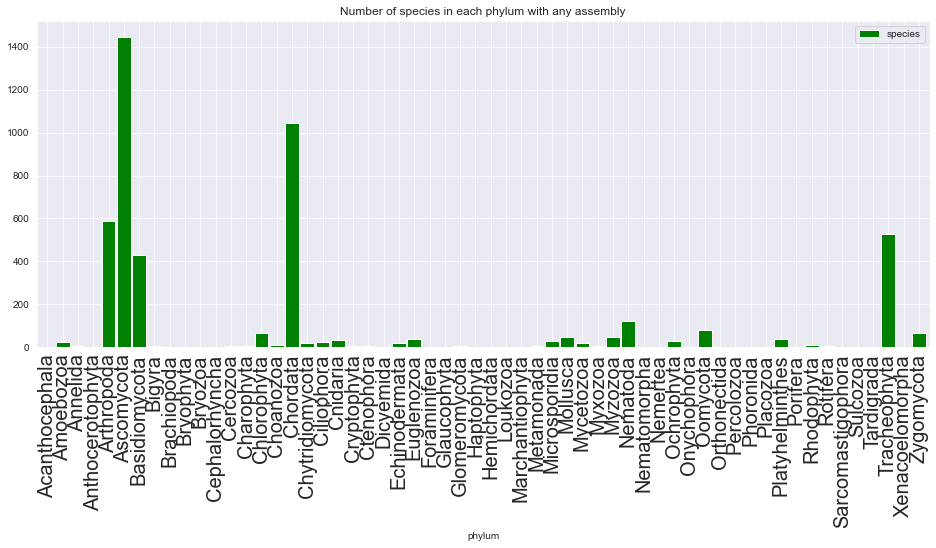

In [46]:
df_species_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with any assembly', figsize=(16,6))
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_phylum.png')

In [47]:
df_species_draft_seq_in_each_kingdom = pd.pivot_table(data=df_draft_all_passing, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_kingdom

,species
kingdom,
Animalia,483
Chromista,29
Fungi,630
Plantae,164
Protozoa,14


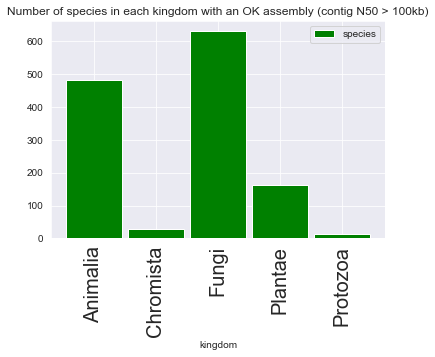

In [48]:
df_species_draft_seq_in_each_kingdom.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each kingdom with an OK assembly (contig N50 > 100kb)')

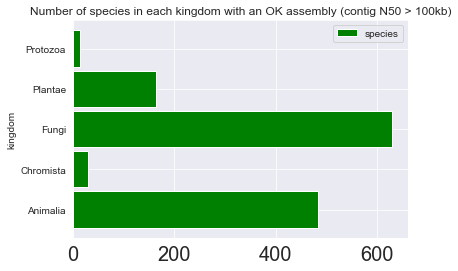

In [49]:
df_species_draft_seq_in_each_kingdom.plot(y='species', kind='barh', width=0.9, color='Green', title='Number of species in each kingdom with an OK assembly (contig N50 > 100kb)')

#### Using the number of species in each kingdom:  
Animal species: 1,312,087  
Plant species: 417,657  
Fungi species: 135,248  
Chromista species: 25,452  
Protozoa species: 2,705  
total eukaryotes: 1,893,149  

In [50]:
# total number of species in each kingdom = 

df_for_Esben = pd.DataFrame({'Kingdom' : ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa'], 
                            'Species' : [1312087, 417657, 135248, 25452, 2705],
                            'Sequenced' : [1595, 521, 1883, 178, 129],
                            })
#df_for_Esben = pd.merge(df_for_Esben, df_species_seq_in_each_kingdom['species'], how='right')
df_for_Esben['% Sequenced'] = df_for_Esben['Sequenced']/df_for_Esben['Species'] * 100
df_for_Esben.set_index('Kingdom', inplace=True)
df_for_Esben

,Species,Sequenced,% Sequenced
Kingdom,,,
Animalia,1312087,1595,0.121562
Plantae,417657,521,0.124744
Fungi,135248,1883,1.392257
Chromista,25452,178,0.699356
Protozoa,2705,129,4.768946


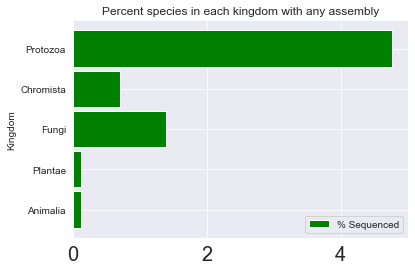

In [51]:
#order = ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa']
df_for_Esben.plot(y='% Sequenced', kind='barh', width=0.9, color='Green', title='Percent species in each kingdom with any assembly')
plt.savefig('NCBI_Genome_stats_images/Percennt_any_assembly_by_kingdom.png')

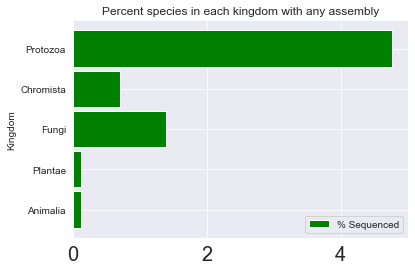

In [52]:
df_plot_for_Esben = pd.DataFrame({'Kingdom' : ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa'], 
                            '% Sequenced' : [0.121562, 0.124744, 1.392257, 0.699356, 4.768946],
                                 })
df_plot_for_Esben.set_index('Kingdom', inplace=True)
df_plot_for_Esben.plot(y='% Sequenced', kind='barh', width=0.9, color='Green', title='Percent species in each kingdom with any assembly')

In [53]:
df_species_seq_in_each_kingdom = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_kingdom

,species
kingdom,
Animalia,1949
Chromista,206
Fungi,1972
Plantae,615
Protozoa,134
incertae sedis,3


In [54]:
df_species_draft_seq_in_each_phylum = pd.pivot_table(data=df_draft_all_passing, index='phylum', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_phylum

,species
phylum,
Amoebozoa,1
Anthocerotophyta,1
Arthropoda,107
Ascomycota,496
Basidiomycota,121
Bigyra,1
Bryophyta,1
Bryozoa,1
Cercozoa,1


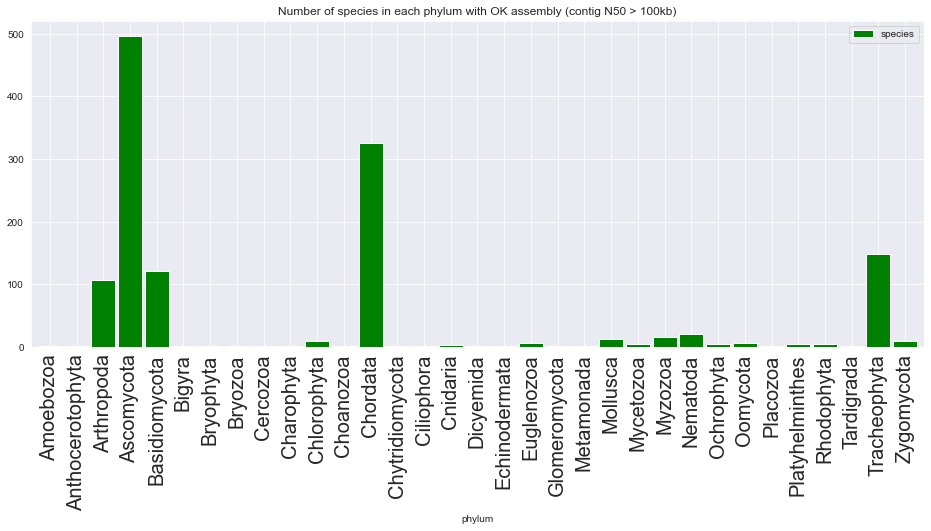

In [55]:
df_species_draft_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with OK assembly (contig N50 > 100kb)', figsize=(16,6))

In [56]:
df_species_draft_seq_in_each_class = pd.pivot_table(data=df_draft_all_passing, index='class', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_class

,species
class,
Actinopterygii,98
Adenophorea,2
Agaricomycetes,46
Agaricostilbomycetes,1
Amphibia,6
...,...
Tremellomycetes,40
Trepomonadea,1
Ulvophyceae,1


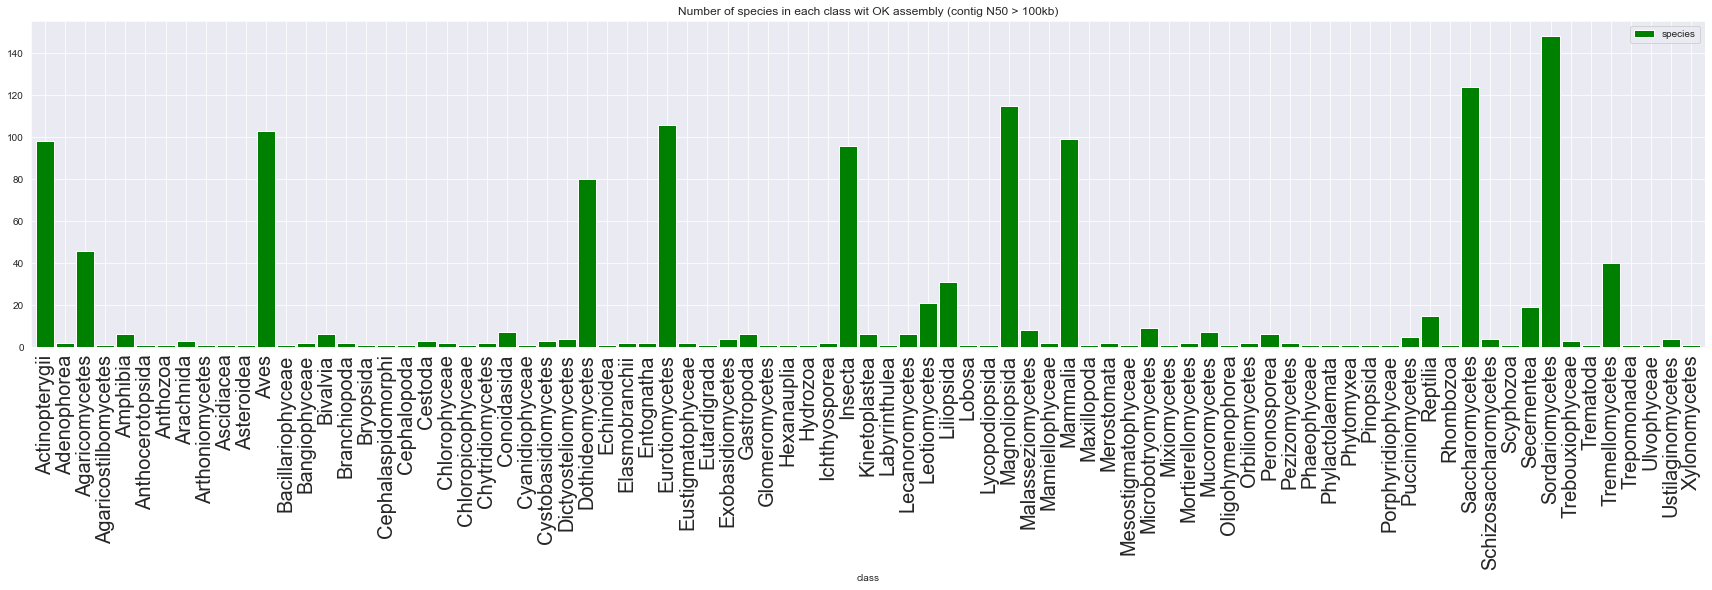

In [57]:
df_species_draft_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of species in each class wit OK assembly (contig N50 > 100kb)', figsize=(30,6))
#df_species_draft_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with OK assembly (contig N50 > 100kb)', figsize=(16,6))
plt.savefig('NCBI_Genome_stats_images/OK_assemblies_by_class.png')

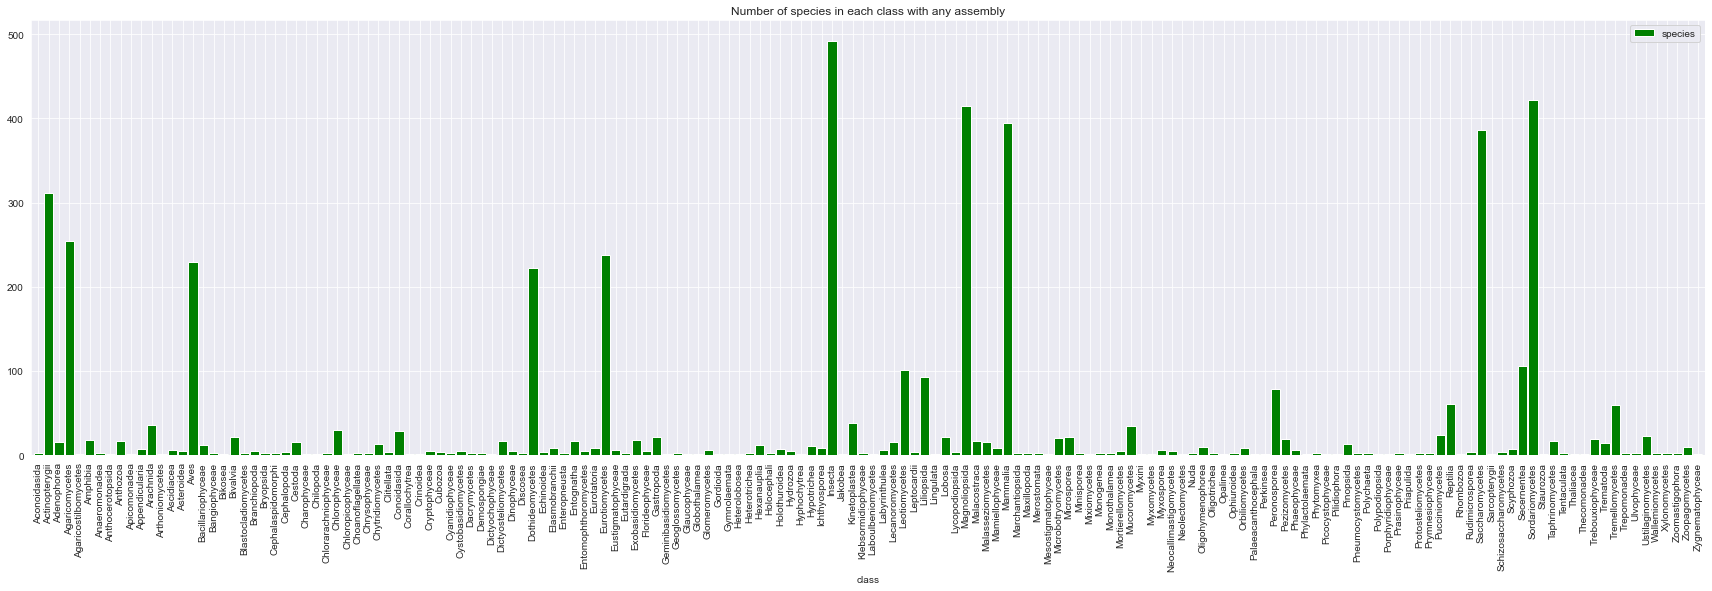

In [58]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data, index='class', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', fontsize='10', title='Number of species in each class with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_class.png')

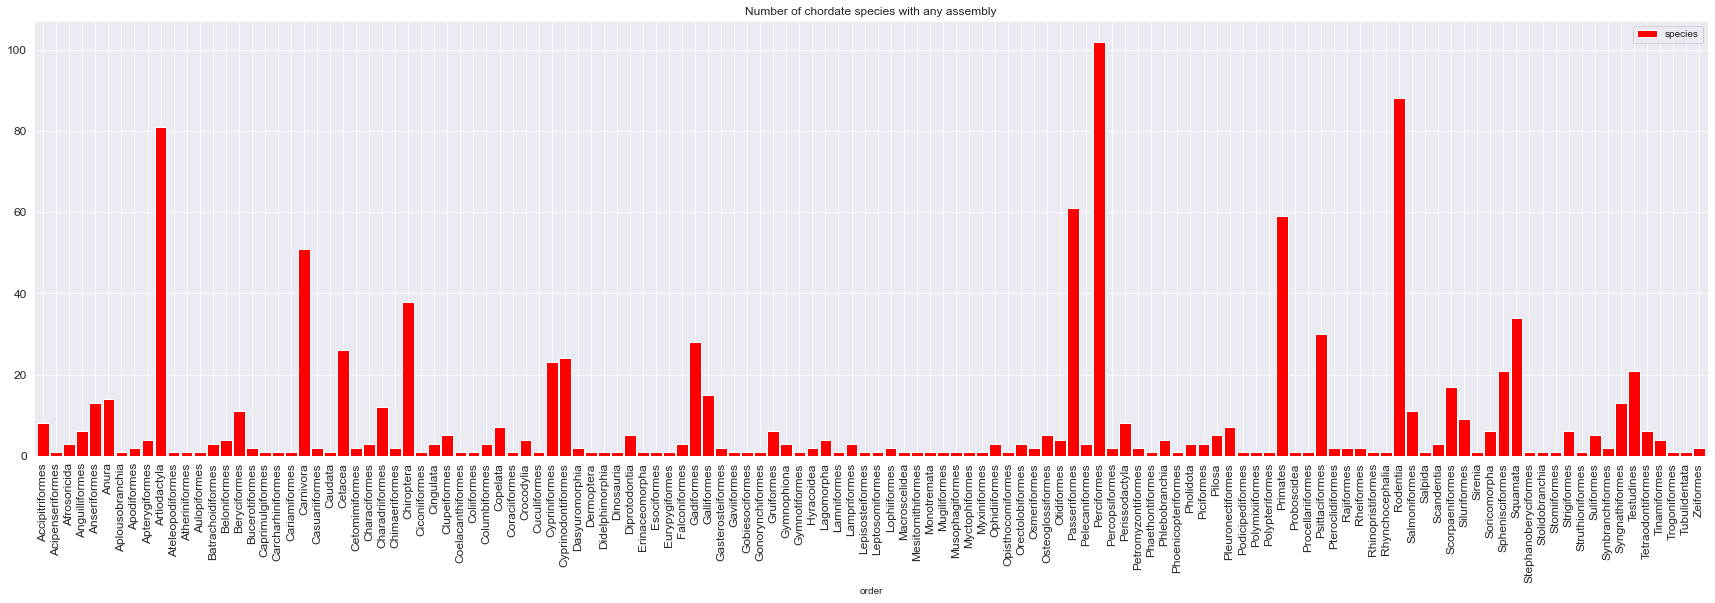

In [59]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['phylum']=='Chordata'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', fontsize=12, width=0.9, color='red', title='Number of chordate species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_chordate_assembly_by_order.png')

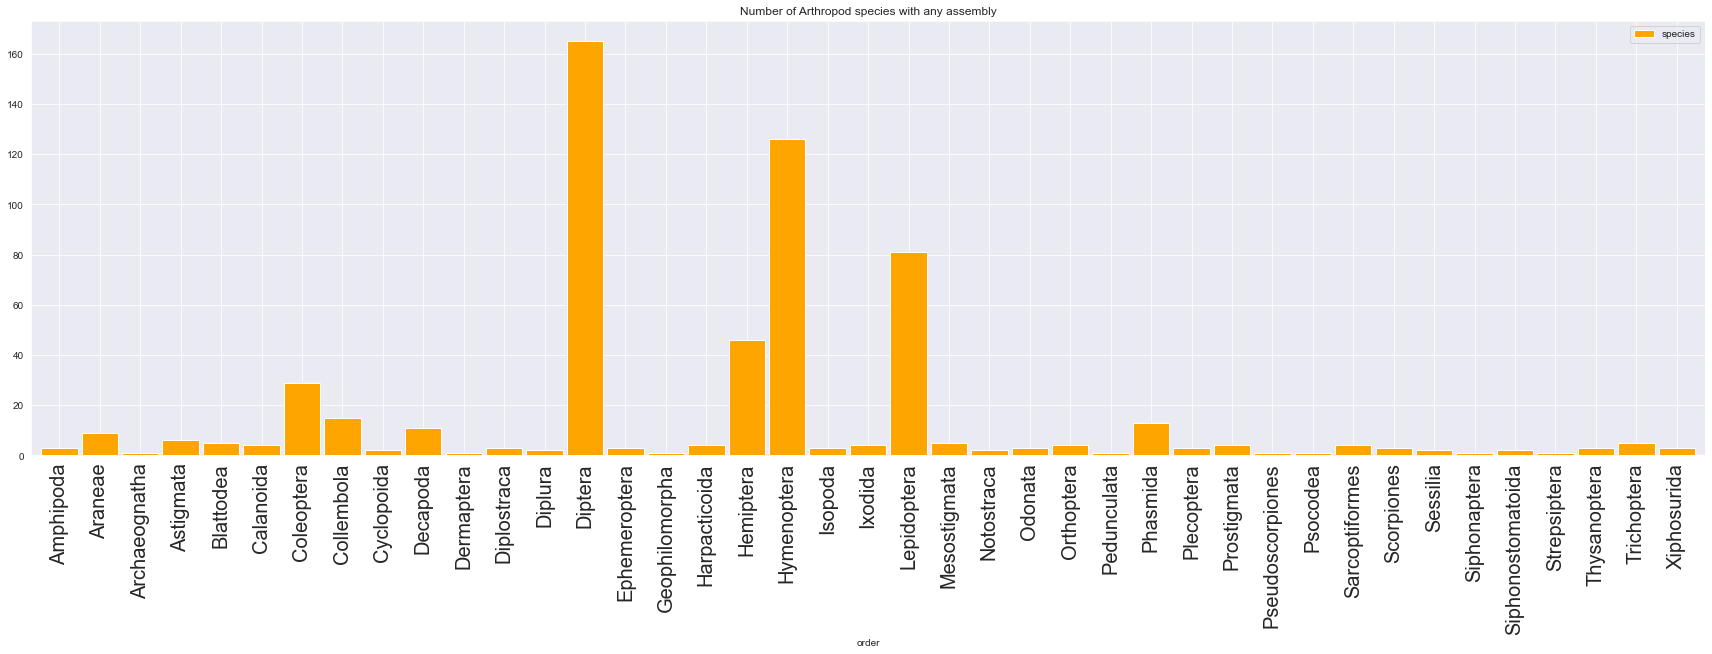

In [60]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['phylum']=='Arthropoda'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='orange', title='Number of Arthropod species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_arthropod_assembly_by_order.png')

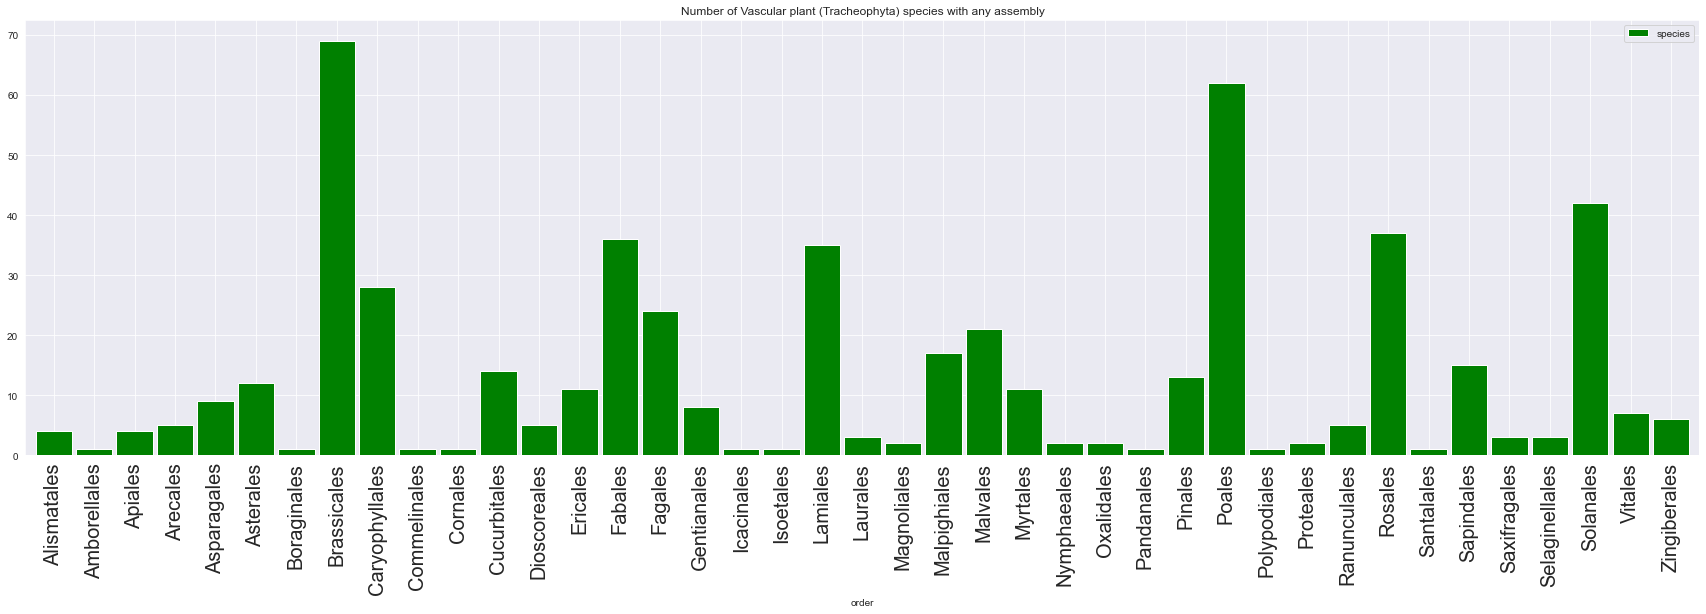

In [61]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups_with_taxon_data[df_sorted_no_dups_with_taxon_data['phylum']=='Tracheophyta'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of Vascular plant (Tracheophyta) species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_vascular_plant_assembly_by_order.png')

/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


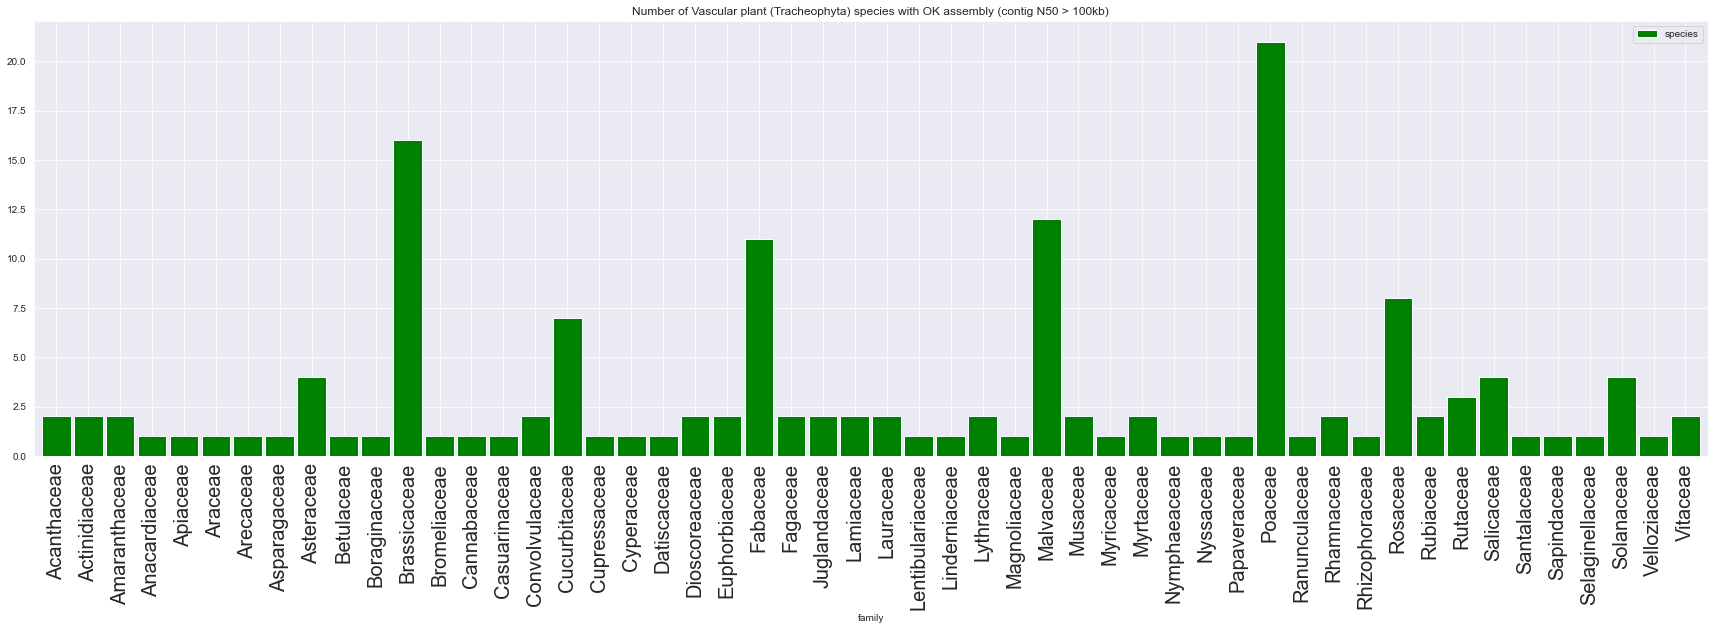

In [62]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_draft_all_passing[df_sorted_no_dups_with_taxon_data['phylum']=='Tracheophyta'], index='family', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of Vascular plant (Tracheophyta) species with OK assembly (contig N50 > 100kb)', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/OK_vascular_plant_assemblies_by_family.png')

### World EBP progress plot for poster ###

In [63]:
# Import libraries
import pandas as pd
import folium
import os

# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
#state_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'us-states.json')
world_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'world-countries.json')


# Load the progress value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
world_progress = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'World-countries_progress.csv')
world_data = pd.read_csv(world_progress)

# load the locations of each EBP Partner:
# note - to find the lat and long, finnd location on gooogle maps, right click and find "What's here?" which will give youo a popup with clickable co-ordinates
df_ebp_partner_locations = pd.read_excel('NCBI_Genome_stats_images/locations_of_EBP_members_with_rockefeller.xlsx')
df_ebp_partner_locations.tail(3)
 
# Initialize the map:
# Add the USGS style map
#url_base = 'http://server.arcgisonline.com/'
#tiles = 'ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
#tileset = url_base + tiles

#m = folium.Map(location=[37, 0], zoom_start=2, control_scale = True, tiles=tileset, attr='USGS style')
m = folium.Map(location=[37, 0], zoom_start=2)


#m = folium.Map(location=[45.5236, -122.6750])  # Folium is really cool,  I need to learn more about how to use it!
# Add the color for the chloropleth:
m.choropleth(
 geo_data=world_geo,
 name='choropleth',
 data=world_data,
 columns=['Country', 'Progress'],
 key_on='feature.properties.name',
 fill_color='YlOrRd',   # after lookng at the others, this is pretty good - contender - good clarity
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Country EBP organization progress (%)', 
    
)
#folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)
 
for i in range(0,len(df_ebp_partner_locations)):
    #print(df_ebp_partner_locations.iloc[i]['latitude'],  df_ebp_partner_locations.iloc[i]['longitude'], df_ebp_partner_locations.iloc[i]['name'])
    folium.Marker([df_ebp_partner_locations.iloc[i]['latitude'], df_ebp_partner_locations.iloc[i]['longitude']], popup=df_ebp_partner_locations.iloc[i]['name'],
                 tooltip=df_ebp_partner_locations.iloc[i]['name'], size=2, radius=5, fill_color='green', color='black', fill_opacity=1, line_opacity=0.1).add_to(m)

#folium.Marker([38.535259, -121.765264], popup='<i>UC Davis Genome Center</i>', tooltip='UC Davis', icon=folium.Icon(color='red'),).add_to(m)
#folium.Marker([52.1874, 0.1208], popup='<i>Sanger Center Center</i>', tooltip='Sanger Center').add_to(m)
#folium.Marker([22.571336, 114.448035], popup='<i>BGI</i>', tooltip='BGI').add_to(m)


#m.add_child(folium.LatLngPopup())
    
# Save to html
m.save('EBP_partner_locations_#292_folium_chloropleth_world1.html')
m

/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
